# Vacancy analysis

We want to estimate the rate of vacancy hopping, to use this as a way to
1. sanity check what is happening in the proxima "no diffusion case"
2. double-check our MSD-based diffusivity calculations
3. check that the vacancy hops follow the expected distribution, sanity checking our science in general

In [1]:
from pathlib import Path
import json
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from tqdm import tqdm
import ase
from ase.io import read

## Reading the data

we'll start with a full dft trajectory

In [2]:
path = Path('runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-01bd9480/')

In [3]:
with open(path/'params.json') as f: 
    params = json.load(f)
params['min_target_frac'] == 1 # shows us this is a DFT-only run

True

In [4]:
traj = read(path/'md.traj', index=':')

In [5]:
len(traj)

40001

In [6]:
atoms = traj[0]

## Testing the vacancy estimation

First we get all of the minimum image distances

In [7]:
D = atoms.get_all_distances(mic=True)

Text(0, 0.5, 'count')

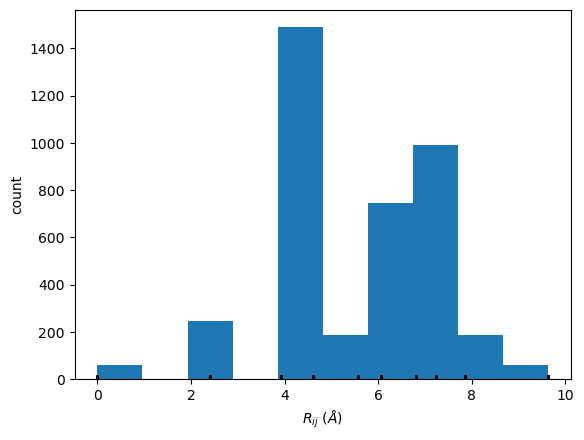

In [8]:
plt.hist(D.ravel());
plt.plot(D.ravel(), [0.1]* len(D.ravel()), '|', color='k');
plt.xlabel('$R_{ij}$ ($\AA$)')
plt.ylabel('count')

The first bin is the self distances (zero), the second bin is likely the covalently bonded Si atoms, lets see what happens if we take a cutoff just above that

In [9]:
r_cut = 3

And then find the number of neighbors

In [10]:
nn = (D < r_cut).sum(1) - 1 # subtract 1 for self distances
pd.Series(nn).value_counts()

4    59
3     4
Name: count, dtype: int64

So 59 of the atoms have 4 neighbors and 4 of them (those near the vacancy) have 3 neighbors. This seems reasonable. 

## Finding vacancy hopping

First lets bundle the code from above

In [11]:
def get_n_neighbors(atoms: ase.Atoms, r_cut: float = 3) -> np.ndarray[int]:
    D = atoms.get_all_distances(mic=True)
    nn = (D < r_cut).sum(1) - 1 # subtract 1 for self distances
    return nn

In [12]:
get_n_neighbors(atoms)

array([3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4])

And loop it over the trajectory, detecting: 

1. when the # neighbors is 'wrong' during a vacancy hop or similar
2. when the distirbution of # neighbors over atoms changes

In [13]:
correct_counts = pd.Series(nn).value_counts()
correct_counts

4    59
3     4
Name: count, dtype: int64

In [14]:
%%time
atoms = traj[0]
nn = get_n_neighbors(atoms)


# track whether a timestep has a 'wrong' or new configuration of neighbors
steps_wrong = np.zeros(len(traj))
steps_new = np.zeros(len(traj))
nn_all = [nn]

for t, atoms in enumerate(traj[1:]):
    print(f'{t}/{len(traj)}', end='\r')
    nn_new = get_n_neighbors(atoms)
    counts = pd.Series(nn_new).value_counts()

    # check whether we have the correct neighbor count distribution
    # handling the case where series comparison is invalid
    try: 
        is_correct = (counts == correct_counts).all()
    except: 
        is_correct = False
    

    # if we do have the correct neighbor count distribution
    # check if the atoms with these counts have changed
    if is_correct: 
        is_new = not (nn == nn_new).all()
        if is_new: 
            # count this as a new state
            steps_new[t] = 1
            # update the reference n_neighbor distribution
            nn = nn_new
    else: 
        steps_wrong[t] = 1

KeyboardInterrupt: 

In [15]:
steps_new.sum()

6.0

In [16]:
steps_wrong.sum()

1398.0

In [17]:
start = 5000
stop  = 8_000

In [18]:
t = np.arange(len(traj))

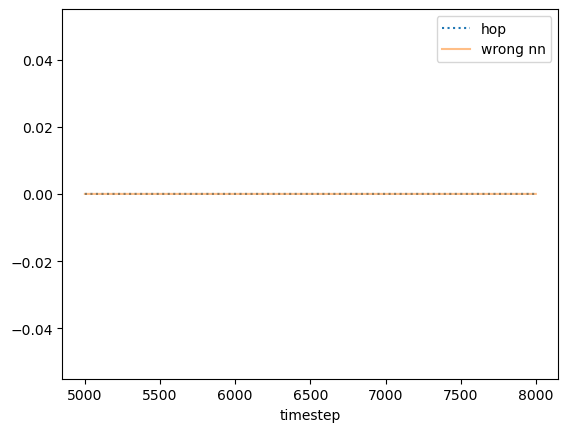

In [19]:
plt.plot(
    t[start:stop],
    steps_new[start:stop], 
    linestyle='dotted', 
    label='hop')
plt.plot(t[start:stop], 
         steps_wrong[start:stop], 
         alpha=0.5, label='wrong nn')
plt.xlabel('timestep')
plt.legend()

## Find the length of time between the hops

In [20]:
hop_indices = np.where(steps_new == 1)[0]
hop_indices

array([ 133,  308, 2398, 2476, 3776, 3829])

In [21]:
durations = np.diff(hop_indices)
durations

array([ 175, 2090,   78, 1300,   53])

In [22]:
hop_indices[0]

133

In [23]:
np.insert(durations, 0, hop_indices[0])

array([ 133,  175, 2090,   78, 1300,   53])

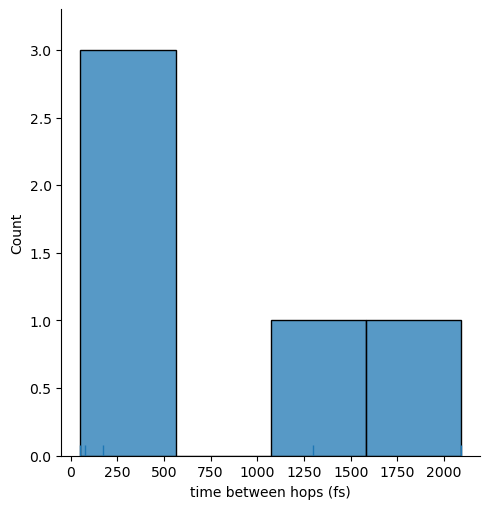

In [24]:
sns.displot(durations, rug=True)
plt.xlabel('time between hops (fs)');

That looks pretty good!

## comparing to no blending proxima:

In [25]:
cat runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-526f7ee4/params.json

{
  "file": null,
  "starting_strc": "../0_setup/initial-geometries/si-vacancy-2x2x2.vasp",
  "temperature": 1573.0,
  "timestep": 1,
  "calculator": "lda",
  "ensemble": "nvt",
  "temp_tau": 25,
  "stress_tau": 25.0,
  "steps": 40000,
  "seed": 9,
  "bulk_modulus": 98.0,
  "initial_volume": 1376.0,
  "model_type": "ani",
  "initial_model": null,
  "initial_data": [],
  "ensemble_size": 2,
  "online_training": true,
  "training_epochs": 16,
  "training_batch_size": 32,
  "training_max_size": 512,
  "training_recency_bias": 1.0,
  "training_device": "cpu",
  "target_error": 0.9,
  "error_history": 8,
  "retrain_freq": 512,
  "min_target_frac": 0.1,
  "n_blending_steps": 0,
  "cascade_commit": "5fda70cf55730fb117bf65924cfd5fae9fd3b0ed",
  "my_commit": "5fda70cf55730fb117bf65924cfd5fae9fd3b0ed",
  "start_time": "2024-10-04T14:28:50.486769"
}

In [26]:
hops = np.load('runs/nvt-fixed-temp/si-vacancy-2x2x2-temp=1573.0-method=lda-blend=0-526f7ee4/hops.npz')

In [27]:
hops['hop_indices'].shape

(212,)

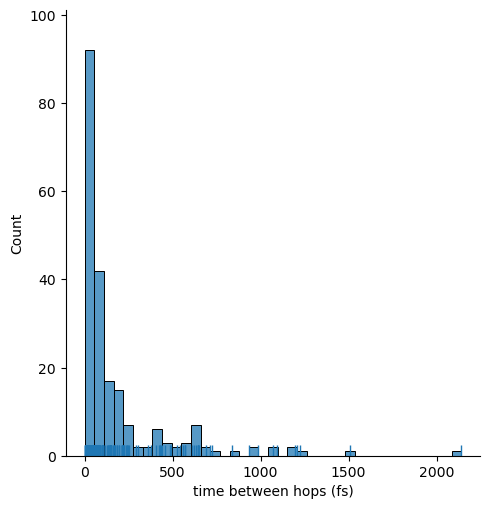

In [28]:
sns.displot(hops['durations'], rug=True)
plt.xlabel('time between hops (fs)');

## Looking at results of the script applied to all of our runs

In [7]:
from glob import glob

In [8]:
run_dirs = glob('runs/nvt-fixed-temp/si-*')

In [13]:
hops['nn_all']

array([[3, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [3, 4, 4, ..., 4, 4, 4],
       ...,
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4]])

In [16]:
hops['nn_all'].shape

(223, 63)

In [22]:
df = []

for d in run_dirs:
    
    d = Path(d)
    with open(d/'params.json') as f: 
        params = json.load(f)

    hops = np.load(d/'hops.npz')
    durations = hops['durations']
    hash_ = str(d)[-8:]
    nunique = np.unique(hops['nn_all'], axis=0).shape[0]

    keep_keys = ['min_target_frac', 'n_blending_steps']
    df.append([params[k] for k in keep_keys] + [durations, hash_, params['target_error'], nunique])
df = pd.DataFrame.from_records(df, columns=keep_keys+['durations', 'hash', 'target_error', 'nunique'])

In [23]:
df['durations'].map(lambda l:list(sorted(l)))

0     [354, 357, 361, 364, 365, 367, 368, 369, 369, ...
1     [821, 823, 827, 832, 833, 834, 834, 837, 838, ...
2     [2167, 2167, 2169, 2171, 2173, 2176, 2176, 217...
3     [1034, 1037, 1043, 1045, 1046, 1047, 1047, 104...
4     [109, 110, 110, 114, 114, 116, 117, 117, 120, ...
5     [720, 721, 724, 731, 733, 736, 737, 738, 739, ...
6     [562, 564, 565, 567, 568, 568, 569, 570, 571, ...
7     [381, 383, 387, 387, 388, 388, 388, 388, 389, ...
8     [114, 122, 129, 133, 133, 134, 135, 135, 138, ...
9     [326, 327, 329, 330, 331, 331, 331, 332, 333, ...
10    [1012, 1015, 1019, 1020, 1022, 1024, 1025, 102...
11    [1006, 1007, 1007, 1010, 1010, 1011, 1012, 101...
12    [138, 139, 139, 141, 141, 143, 143, 144, 146, ...
13    [1715, 1716, 1719, 1719, 1720, 1721, 1721, 172...
14    [358, 359, 360, 363, 363, 366, 367, 367, 369, ...
15    [561, 563, 564, 570, 571, 573, 573, 574, 576, ...
16    [138, 140, 140, 144, 146, 148, 148, 152, 152, ...
17    [1025, 1025, 1027, 1027, 1028, 1028, 1030,

In [24]:
df['durations'].map(lambda l:len(l))

0     117
1     103
2      90
3      94
4     117
5     103
6     188
7     213
8      92
9     211
10     97
11    193
12    145
13     96
14    129
15    119
16     94
17    238
18    108
19     70
20    197
21    119
22    103
23    117
24    139
25    100
26    106
27    182
28    192
29    221
Name: durations, dtype: int64

In [25]:
df['durations'].map(sum)

0      79764
1     122779
2     232009
3     134760
4      51704
5     109925
6     143847
7     120193
8      49035
9     108128
10    136062
11    232136
12     59102
13    200367
14     84684
15    105464
16     50504
17    281667
18     74723
19     66137
20     59522
21     54432
22    527249
23     77097
24    116359
25    135796
26     79303
27    173482
28    106680
29    272885
Name: durations, dtype: int64

In [26]:
df['durations'][22].sum()

527249

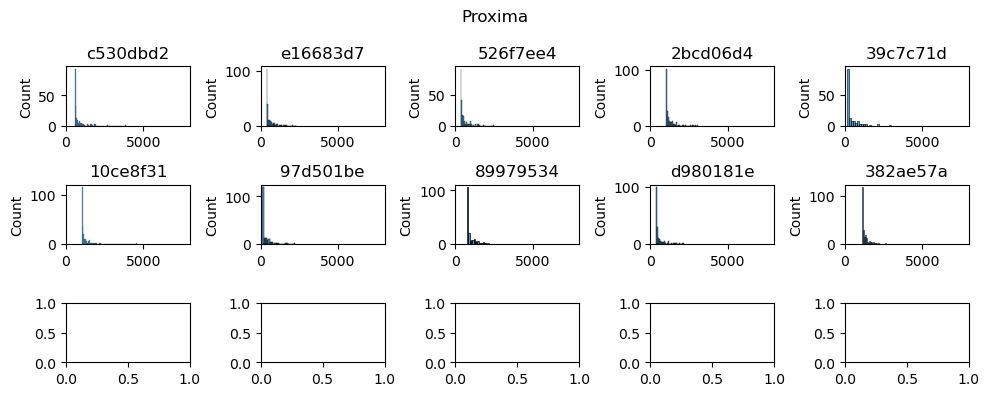

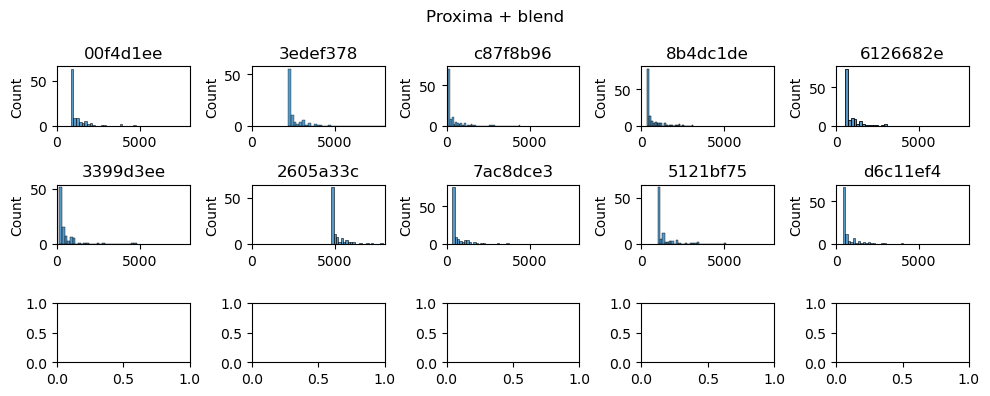

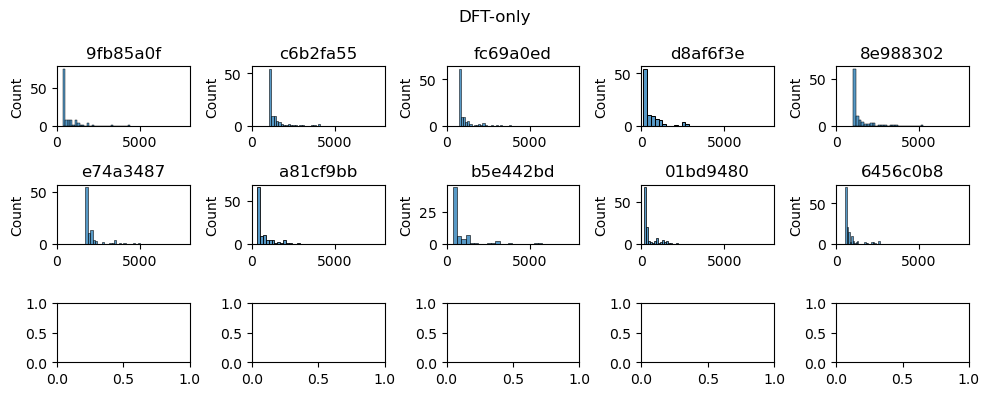

In [27]:
for (frac, n_blend), g in df.groupby(['min_target_frac', 'n_blending_steps']): 
    fig, axs = plt.subplots(3, 5, figsize=(10,4))
    for i, (_, row) in enumerate(g.iterrows()):
        ax = axs.ravel()[i]
        sns.histplot(row['durations'], ax=ax)
        ax.set_title(row['hash'])
        ax.set_xlim(0, 8000)
    if frac == 1: 
        title = 'DFT-only'
    elif n_blend == 0: 
        title = 'Proxima'
    else:
        title = 'Proxima + blend'
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

Actually, lets just combine them  

In [28]:
row

min_target_frac                                                   1.0
n_blending_steps                                                    0
durations           [593, 724, 627, 834, 573, 600, 770, 612, 942, ...
hash                                                         6456c0b8
target_error                                                      0.9
nunique                                                            69
Name: 24, dtype: object

In [46]:
new_df = []
for (frac, n_blend, t), g in df.groupby(['min_target_frac', 'n_blending_steps', 'target_error']): 
    durations = []
    nunique = []
    for i, (_, row) in enumerate(g.iterrows()):
        durations.extend(row['durations'])
        nunique.append(row['nunique'])
        
    if frac == 1: 
        title = 'DFT-only'
    elif n_blend == 0: 
        title = 'Proxima'
    elif t == 0.9:
        title = 'Proxima + blend'
    else: 
        title='Proxima + blend (high target)'
    new_df.append([title, durations, nunique])
new_df = pd.DataFrame(new_df, columns=['condition', 'duration', 'nunique'])

In [47]:
df.shape

(30, 6)

In [48]:
new_df

,condition,duration,nunique
0,Proxima,"[590, 1609, 591, 921, 609, 1081, 590, 1061, 58...","[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]"
1,Proxima + blend,"[901, 1144, 940, 4749, 855, 1722, 847, 1202, 8...","[51, 35, 65, 74, 64, 52, 53, 57, 44, 61]"
2,DFT-only,"[369, 1192, 470, 371, 446, 384, 713, 427, 404,...","[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]"


In [49]:
new_df.shape

(3, 3)

In [50]:
df_long = new_df.explode('duration')

In [51]:
df_long

,condition,duration,nunique
0,Proxima,590,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]"
0,Proxima,1609,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]"
0,Proxima,591,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]"
0,Proxima,921,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]"
0,Proxima,609,"[107, 110, 122, 97, 76, 123, 101, 102, 100, 116]"
...,...,...,...
2,DFT-only,599,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]"
2,DFT-only,1324,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]"
2,DFT-only,595,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]"
2,DFT-only,936,"[62, 39, 44, 41, 37, 37, 42, 37, 54, 69]"


<Axes: xlabel='condition', ylabel='duration'>

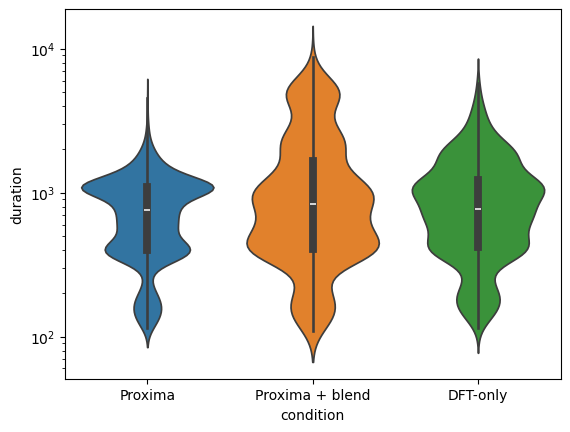

In [35]:
sns.violinplot(x='condition', 
            y='duration',
            hue='condition',
            log_scale=True,
            data=df_long)#.sample(frac=0.5))
#plt.yscale('log')

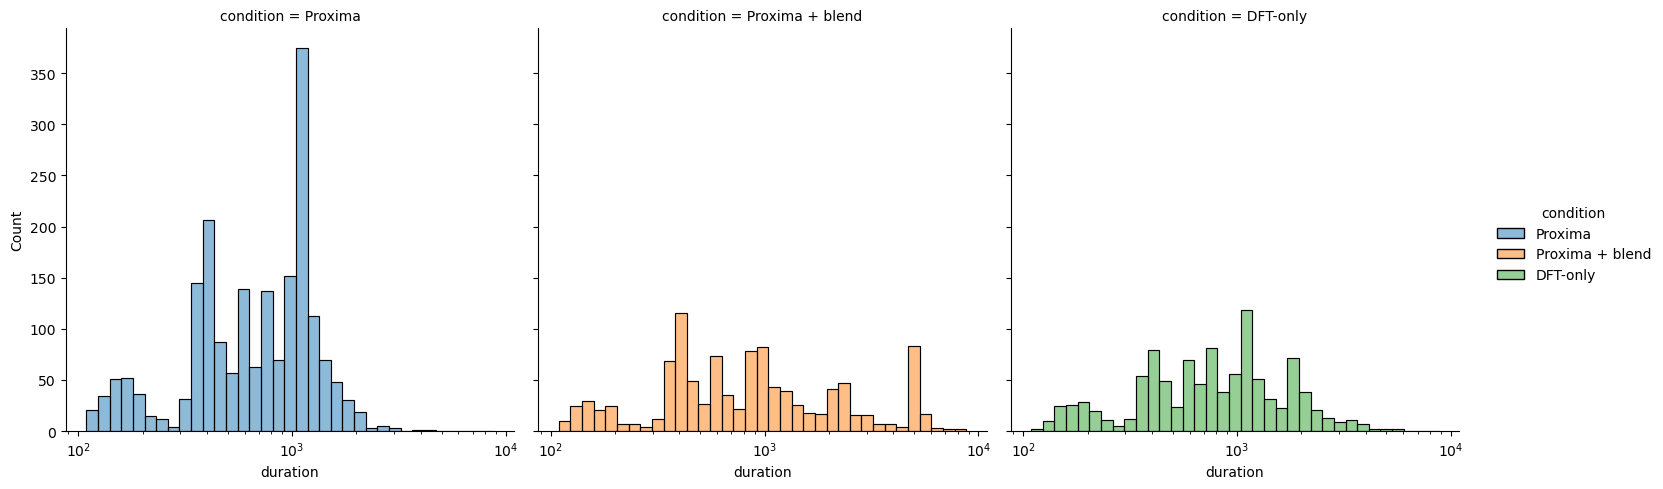

In [36]:
sns.displot(x='duration',
            col='condition',
            hue='condition',
            log_scale=(True, False),
            #rug=True,
            data=df_long)#.sample(frac=0.5))


In [37]:
means = df_long.groupby('condition').mean()#.reset_index()
means

,duration
condition,
DFT-only,987.018357
Proxima,786.687879
Proxima + blend,1360.472171


In [38]:
1/means

,duration
condition,
DFT-only,0.001013
Proxima,0.001271
Proxima + blend,0.000735


In [39]:
means['duration']  / np.sqrt(df_long.groupby('condition').size())

condition
DFT-only           30.679979
Proxima            17.679495
Proxima + blend    41.436234
dtype: object

In [27]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [28]:
df_long

,condition,duration
0,Proxima,34
0,Proxima,1053
0,Proxima,35
0,Proxima,365
0,Proxima,53
...,...,...
2,DFT-only,44
2,DFT-only,769
2,DFT-only,40
2,DFT-only,381


In [32]:
df_long['duration'] = df_long['duration'].astype(int)

In [33]:
df_long['condition'] = pd.Categorical(df_long['condition'])

In [34]:
formula = 'duration ~ C(condition)'

In [35]:
mod1 = smf.glm(formula=formula, data=df_long, family=sm.families.Poisson()).fit()
print(mod1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               duration   No. Observations:                 4093
Model:                            GLM   Df Residuals:                     4090
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0210e+06
Date:                Mon, 04 Nov 2024   Deviance:                   2.0155e+06
Time:                        11:20:44   Pearson chi2:                 3.30e+06
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

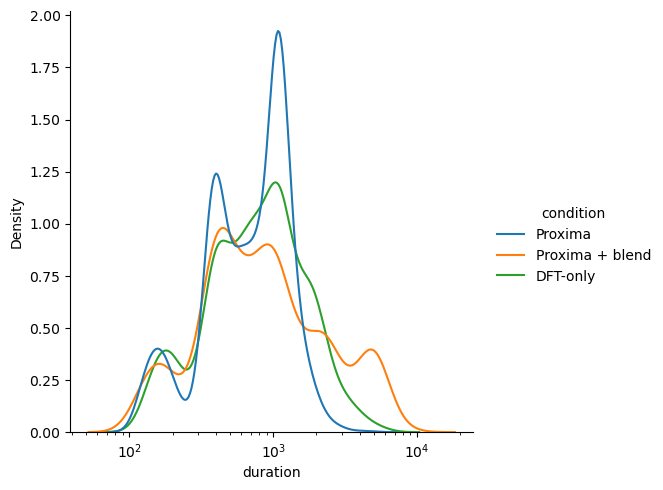

In [40]:
sns.displot(x='duration',
            #col='condition',
            hue='condition',
            log_scale=(True, False),
            #rug=True,
            common_norm=False,
            kind='kde',
            data=df_long)


In [44]:
df_long

,condition,duration
0,Proxima,590
0,Proxima,1609
0,Proxima,591
0,Proxima,921
0,Proxima,609
...,...,...
2,DFT-only,599
2,DFT-only,1324
2,DFT-only,595
2,DFT-only,936


In [55]:
df_long = new_df.explode('nunique')

<Axes: xlabel='condition', ylabel='nunique'>

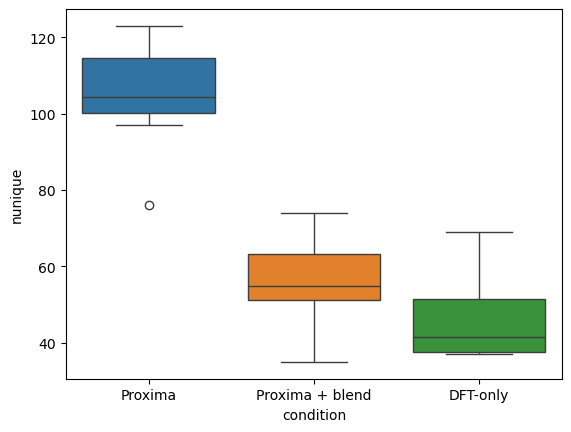

In [58]:
sns.boxplot(data=df_long,x='condition', hue='condition', y='nunique')

<Axes: xlabel='condition', ylabel='nunique'>

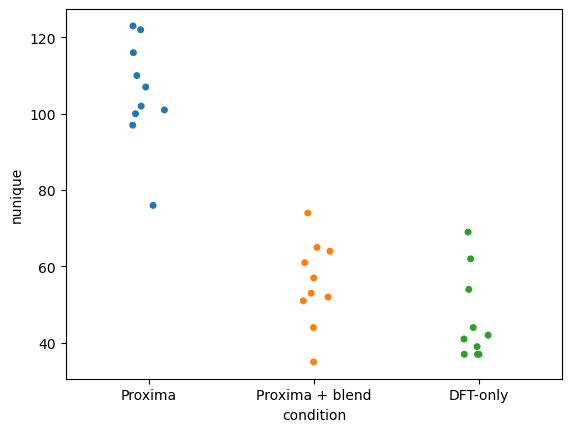

In [59]:
sns.stripplot(data=df_long,x='condition', hue='condition', y='nunique')